<a href="https://colab.research.google.com/github/ThomasWit21/Master-thesis/blob/main/Master_Thesis_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing the relevant packages
import numpy as np 
import pandas as pd
import matplotlib as plt
import sklearn

In [ ]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading tweets
tweets_df = pd.read_csv("/content/drive/My Drive/Tweets.csv")

In [ ]:
#Information about dataset
len(tweets_df)
print(f"data shape: {tweets_df.shape}")
tweets_df.info()


data shape: (1385469, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385469 entries, 0 to 1385468
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   text          1385469 non-null  object 
 1   tweet_id      1385469 non-null  int64  
 2   nbr_retweet   1385469 non-null  int64  
 3   nbr_favorite  1385469 non-null  int64  
 4   nbr_reply     1385469 non-null  int64  
 5   datetime      1385469 non-null  object 
 6   is_reply      1385469 non-null  bool   
 7   is_retweet    1385469 non-null  bool   
 8   hashtags      1385469 non-null  object 
 9   mentions      1385469 non-null  object 
 10  has_media     193579 non-null   float64
 11  medias        193579 non-null   object 
dtypes: bool(2), float64(1), int64(4), object(5)
memory usage: 108.3+ MB


In [ ]:
#Deleting all irrelevant columns
tweets_df = tweets_df.drop(["tweet_id", "nbr_retweet", "nbr_favorite", "nbr_reply", "is_reply", "is_retweet", "hashtags", "mentions", "has_media", "medias"], axis = 1)

In [ ]:
##Is there any missing data?
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))
missing_data(tweets_df)

,text,datetime
Total,0,0
Percent,0,0
Types,object,object


Preprocessing

In [ ]:
#Removing the punctuation
import string
import re
string.punctuation

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+http\S?:\/\/.*[\r\n]*', '', text)
    return text

tweets_df['Tweet_punct'] = tweets_df['text'].apply(lambda x: remove_punct(x))

In [ ]:
##Tokenize the tweet texts and remove upper case letter
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
tweets_df['tokenized_tweets'] = tweets_df['Tweet_punct'].apply(lambda x: tt.tokenize(x.lower()))

In [ ]:
#Removing English stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tweets_df['Tweet_nonstop'] = tweets_df['tokenized_tweets'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
##Sentiment analysis using VADER
#import nltk
#nltk.download('vader_lexicon')
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

#sentiment = []
#def analyze_sentiment_vader_lexicon(review, 
#                                    threshold=0.1,
#                                    verbose=False):    
    # analyze the sentiment for review
#    analyzer = SentimentIntensityAnalyzer()
#    scores = analyzer.polarity_scores(review)
#    agg_score = scores['compound']
#    final = round(agg_score, 2)
#    sentiment.append(final)

#for text in tweets_df.text:
#  analyze_sentiment_vader_lexicon(text, threshold=0.4, verbose=True)

#import pandas
#df = pandas.DataFrame(data={"col1": sentiment})
#df.to_csv("./file.csv", sep=',',index=False)

sentiment = pd.read_csv("/content/drive/My Drive/SentimentScores.csv")
tweets_df['Sentiment Score'] = pd.DataFrame(sentiment)

In [ ]:
#pip install afinn

In [ ]:
##Loading in the AFINN Lexicon
#from afinn import Afinn
#afinn = Afinn()
#def sentiment_score(text):
#  sentiment_scores = [afinn.score(tweet_nonstop) for tweet_nonstop in tweets_df]   
#  return sentiment_scores
    
#tweets_df['Afinn_sentiment'] = tweets_df['Tweet_nonstop'].apply(lambda x: sentiment_score(x))

In [ ]:
##Rounding the sentiments
def round_sentiment(x):
    if x >= 0.0 and x < 0.04:
      return 0
    elif x >= 0.04:
      return 1
    elif x < 0.0:
      return -1

rounded = []
for x in tweets_df['Sentiment Score']:
  rounded.append(round_sentiment(x))

tweets_df['Sentiment rounded'] = rounded

In [ ]:
##Splitting the time and date
days = [item.split(" ")[0] for item in tweets_df['datetime'].values]
tweets_df['days'] = days

In [ ]:
##Summarize amount of tweets and the mean sentiment per day
mean = tweets_df.groupby(tweets_df['days']) \
       .agg(count=('text', 'size'), mean = ('Sentiment rounded', 'mean')) \
       .reset_index()

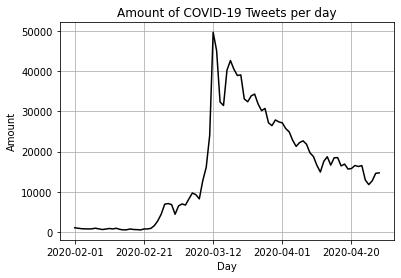

In [ ]:
#Count of tweets per day
mean_scores = mean.unstack()
mean_scores = mean_scores.xs('count')
# Plot a bar chart with pandas
plt.pyplot.xlabel('Day')
plt.pyplot.ylabel('Amount')
plt.pyplot.title('Amount of COVID-19 Tweets per day')
x = np.array([0,20,40,60,80])
xticks = ['2020-02-01', '2020-02-21', '2020-03-12', '2020-04-01', '2020-04-20']
plt.pyplot.xticks(x, xticks, rotation = 45)
mean_scores.plot(kind = 'line', x = 'days', color = 'black')
plt.pyplot.grid()

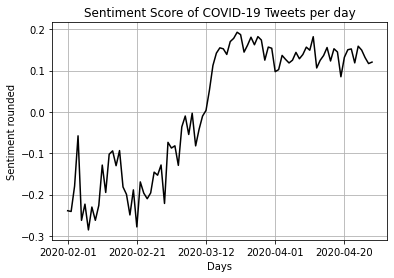

In [ ]:
#Count of sentiment score per day
plt.pyplot.xlabel('Days')
plt.pyplot.ylabel('Sentiment rounded')
plt.pyplot.title('Sentiment Score of COVID-19 Tweets per day')
x = np.array([0,20,40,60,80])
xticks = ['2020-02-01', '2020-02-21', '2020-03-12', '2020-04-01', '2020-04-20']
plt.pyplot.xticks(x, xticks, rotation = 45)
mean['mean'].plot(kind = 'line', x = 'days', color = 'black')
plt.pyplot.grid()

In [ ]:
DJIA = pd.read_csv("/content/drive/My Drive/DJIA Concave filled.csv", sep = ';')

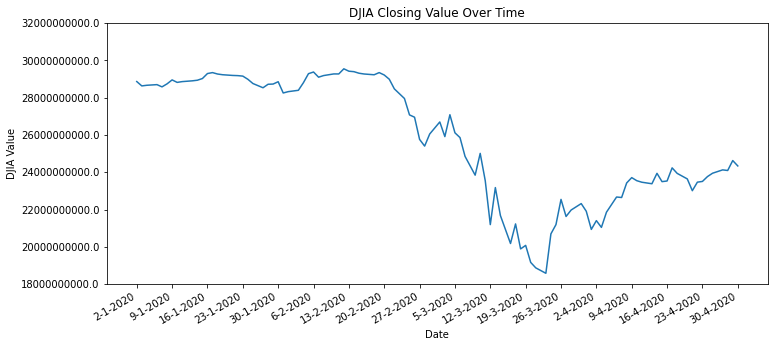

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig = plt.pyplot.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(DJIA['Date'],DJIA['Close'], label='Values')
ax.set(title='DJIA Closing Value Over Time', xlabel='Date', ylabel='DJIA Value')
fig.tight_layout()
fig.autofmt_xdate()
plt.pyplot.xticks(np.arange(0, len(DJIA['Date'])+1, 7))
y_formatter = ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
locs,labels = plt.pyplot.yticks()
plt.pyplot.yticks(locs, map(lambda x: "%.1f" % x, locs*1e0))
plt.pyplot.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


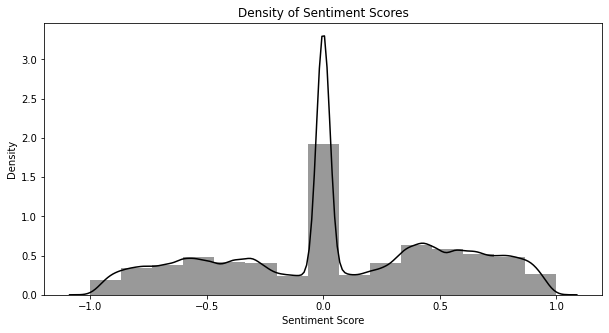

In [ ]:
#Checking the density of the Sentiment Scores (Note: if 0 sentiment not included, the average would be much higher)
import seaborn as sns
fig = plt.pyplot.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title = 'Density of Sentiment Scores')
sns.distplot(tweets_df['Sentiment Score'], bins=15, ax=ax, color = 'k')
plt.pyplot.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


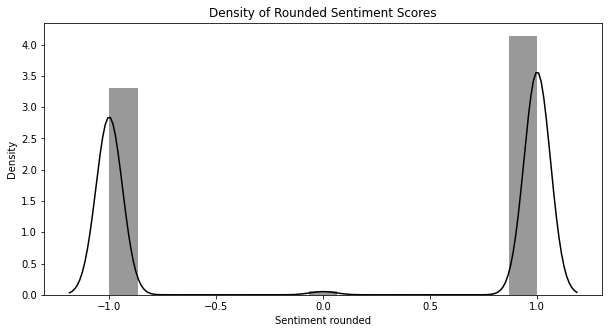

In [ ]:
#Checking the density of the Sentiment Scores (Note: if 0 sentiment not included, the average would be much higher)
import seaborn as sns
fig = plt.pyplot.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title = 'Density of Rounded Sentiment Scores')
sns.distplot(tweets_df['Sentiment rounded'], bins=15, ax=ax, color = 'k')
plt.pyplot.show()

**Checking VADER against labeled tweets**

In [ ]:
#Vadercheck = pd.read_csv("/content/drive/My Drive/VADERcheck.csv", encoding = "ISO-8859-1")
#Vadercheck = Vadercheck.drop(['1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_'], axis = 1)
#Vadercheck = Vadercheck.rename(columns = {'0' : 'Sentiment Score', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : "Text"})
#Samplecheck = Vadercheck.sample(n=100000)

In [ ]:
#import nltk
#nltk.download('vader_lexicon')
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Sentimentcheck = []
#def analyze_sentiment_vader_lexicon(review, 
#                                    threshold=0.1,
#                                    verbose=False):    
    # analyze the sentiment for review
#    analyzer = SentimentIntensityAnalyzer()
#    scores = analyzer.polarity_scores(review)
#    agg_score = scores['compound']
#    final = round(agg_score, 2)
#    Sentimentcheck.append(final)

#for text in Samplecheck.Text:
#  analyze_sentiment_vader_lexicon(text, threshold=0.4, verbose=True)

#Samplecheck['Checked'] = Sentimentcheck
Samplecheck = pd.read_csv("/content/drive/My Drive/Vader checks.csv")


In [ ]:
#Samplecheck.to_csv("./file.csv", sep=',',index=False)

In [ ]:
def round_vader_sentiment(x):
    if x >= 0.0 and x <= 0.04:
      return 2
    elif x > 0.04:
      return 4
    elif x < 0.00:
      return 0

roundedVADER = []
for x in Samplecheck['Checked']:
  roundedVADER.append(round_vader_sentiment(x))

In [ ]:
Samplecheck['Checkedrounded'] = roundedVADER

In [ ]:
y_pred = Samplecheck['Checkedrounded']
y_test = Samplecheck['Sentiment Score']  

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

array([[34388,     0, 19060],
       [  277,     0,   112],
       [15653,     0, 30510]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.64898

**Results Section**

Normalizing and Granger Causality test


In [ ]:
def z_score(df):
    df_std = df.copy()
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

In [ ]:
mean['DJIA'] = DJIA['Difference']

In [ ]:
#Standardizing
mean_standardized = z_score(pd.DataFrame(mean['mean']))
mean['Mean_STAND'] = mean_standardized

DJIA_difference_standardized = z_score(pd.DataFrame(mean['DJIA']))
mean['DJIA_DIF_STAND'] = DJIA_difference_standardized

mean['DJIA_Close_stand'] = z_score(pd.DataFrame(DJIA['Close']))


([<matplotlib.axis.XTick at 0x7f0e3b725438>,
 [Text(0, 0, '2020-02-01'),
  Text(0, 0, '2020-02-21'),
  Text(0, 0, '2020-03-12'),
  Text(0, 0, '2020-04-01'),
  Text(0, 0, '2020-04-20')])

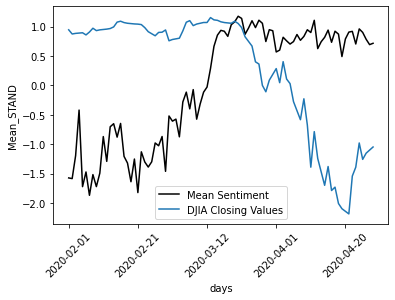

In [ ]:
#Visualizing the relationship Sentiment and Closing Value
ax = sns.lineplot(x="days", y="Mean_STAND", data=mean, color = 'k', label = 'Mean Sentiment')
ax1 = sns.lineplot(x="days", y='DJIA_Close_stand', data=mean, label = "DJIA Closing Values")
x = np.array([0,20,40,60,80])
xticks = ['2020-02-01', '2020-02-21', '2020-03-12', '2020-04-01', '2020-04-20']
plt.pyplot.xticks(x, xticks, rotation = 45)

([<matplotlib.axis.XTick at 0x7f0e3b634860>,
 [Text(0, 0, '2020-02-01'),
  Text(0, 0, '2020-02-21'),
  Text(0, 0, '2020-03-12'),
  Text(0, 0, '2020-04-01'),
  Text(0, 0, '2020-04-20')])

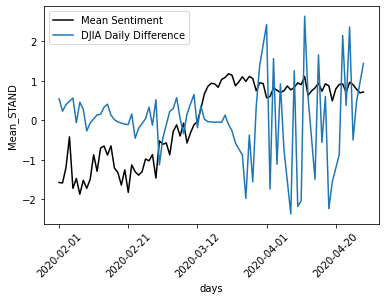

In [ ]:
#Visualizing the relationship Sentiment and Difference Value
ax = sns.lineplot(x="days", y="Mean_STAND", data=mean, color = 'k', label = 'Mean Sentiment')
ax1 = sns.lineplot(x="days", y='DJIA_DIF_STAND', data=mean, label = "DJIA Daily Difference")
x = np.array([0,20,40,60,80])
xticks = ['2020-02-01', '2020-02-21', '2020-03-12', '2020-04-01', '2020-04-20']
plt.pyplot.xticks(x, xticks, rotation = 45)

In [ ]:
Listy = []
for x in mean['DJIA']:
  if x > 0:
    Listy.append(1)
  else:
    Listy.append(0)
mean['Target'] = Listy

In [ ]:
#Granger causality test
from statsmodels.tsa.stattools import grangercausalitytests
res = grangercausalitytests(mean[['mean', 'Target']], maxlag=15)\

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1902  , p=0.6639  , df_denom=85, df_num=1
ssr based chi2 test:   chi2=0.1969  , p=0.6572  , df=1
likelihood ratio test: chi2=0.1967  , p=0.6574  , df=1
parameter F test:         F=0.1902  , p=0.6639  , df_denom=85, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7898  , p=0.4573  , df_denom=82, df_num=2
ssr based chi2 test:   chi2=1.6760  , p=0.4326  , df=2
likelihood ratio test: chi2=1.6600  , p=0.4360  , df=2
parameter F test:         F=0.7898  , p=0.4573  , df_denom=82, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6677  , p=0.5744  , df_denom=79, df_num=3
ssr based chi2 test:   chi2=2.1805  , p=0.5358  , df=3
likelihood ratio test: chi2=2.1533  , p=0.5412  , df=3
parameter F test:         F=0.6677  , p=0.5744  , df_denom=79, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2583  , p=0.2939  , df_d

In [ ]:
from sklearn.model_selection import train_test_split
X = mean
X = np.array(mean['Mean_STAND'])
Y = np.array(mean['Target'])

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.15, random_state=69)

X_test = X_test.reshape(-1, 1)
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

In [ ]:
#Random Forest naive
from sklearn.ensemble import RandomForestClassifier

#Training classifier
classifier = RandomForestClassifier(n_estimators = 50)
classifier.fit(X_train, Y_train)

#Making predictions
y_pred = classifier.predict(X_test)
round(classifier.score(X_test,Y_test), 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.5

In [ ]:
#Logistic Regression naive
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, Y_train)
LR.predict(X_test)
round(LR.score(X_test,Y_test), 4)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7143

In [ ]:
#Support Vector Machine naive
from sklearn import svm
SVM = svm.SVC(decision_function_shape="ovo").fit(X_train, Y_train)
SVM.predict(X_test)
round(SVM.score(X_test, Y_test), 4)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6429

In [ ]:
#Multilayer Perceptron
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(X_train, Y_train)
NN.predict(X_test)
round(NN.score(X_test, Y_test), 4)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.4286

In [ ]:
#Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis().fit(X_train, Y_train)
predictions = model.predict(X_test)
predictions
round(model.score(X_test, Y_test), 4)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7143

CNN MODEL


In [ ]:
from sklearn.model_selection import train_test_split
X = mean
X = np.array(mean['Mean_STAND'], dtype='float32')
Y = np.array(mean['Target'], dtype='int32')

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.15, random_state=69)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense 
model = Sequential()
model.add(Flatten())
model.add(Dense(4, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 1)

Epoch 1/10
75/75 [==============================] - 0s 966us/step - loss: 0.6959 - accuracy: 0.4267
Epoch 2/10
75/75 [==============================] - 0s 943us/step - loss: 0.6953 - accuracy: 0.4533
Epoch 3/10
75/75 [==============================] - 0s 908us/step - loss: 0.6948 - accuracy: 0.4400
Epoch 4/10
75/75 [==============================] - 0s 926us/step - loss: 0.6945 - accuracy: 0.4400
Epoch 5/10
75/75 [==============================] - 0s 962us/step - loss: 0.6943 - accuracy: 0.4133
Epoch 6/10
75/75 [==============================] - 0s 928us/step - loss: 0.6940 - accuracy: 0.4933
Epoch 7/10
75/75 [==============================] - 0s 908us/step - loss: 0.6937 - accuracy: 0.5333
Epoch 8/10
75/75 [==============================] - 0s 941us/step - loss: 0.6933 - accuracy: 0.5333
Epoch 9/10
75/75 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5333
Epoch 10/10
75/75 [==============================] - 0s 916us/step - loss: 0.6928 - accuracy: 0.5333


In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.6429


In [ ]:
test_acc

0.6428571343421936